In [26]:
## Imports

import argparse
import math
from qiskit import  ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeProviderForBackendV2 as FakeProvider
from qiskit.circuit.library import QFT
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [27]:
## Input
operator = "Z"     # "Z", "Y" or "RX"
theta = math.pi/2  # angle for RX operator
eigenvector = "e0" # "e0 or "e1"
bits = 2
provider = "aer"
shots = 1024

In [28]:
## Initialize
input_qubit = 0
n = bits

qubits = QuantumRegister(n+1, "q")
clbits = ClassicalRegister(n, "c")
circuit = QuantumCircuit(qubits, clbits)

In [29]:
## Build circuit

# Input state
if operator == "Z":
    if eigenvector == "e0":
        circuit.x(input_qubit)
elif operator == "Y":
    if eigenvector == "e0":
        circuit.rx(math.pi/2, input_qubit)
    else:
        circuit.rx(-math.pi/2, input_qubit)
else:
    if eigenvector == "e0":
        circuit.ry(math.pi/2, input_qubit)
    else:
        circuit.ry(-math.pi/2, input_qubit)

# Prepare input for QFT:
for i in range(n):
    circuit.h(i+1)
for i in range(n):
    if operator == "Z" and i % 2 == 1:
        circuit.cz(n-i, input_qubit)
    elif operator == "Y" and i % 2 == 1:
        circuit.cy(n-i, input_qubit)
    elif operator == "RX":
        circuit.crx(theta*(2**(n-i-1)), n-i, input_qubit)

# QFT:
circuit.append(QFT(n).inverse(), qubits[1:])

# Measure:
circuit.measure(qubits[1:], clbits)

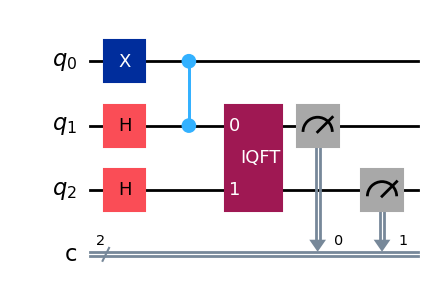

In [30]:

## Diagram
circuit.draw(output="mpl")

In [31]:
## Run
backend = AerSimulator()
sampler = Sampler(backend)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
job = sampler.run([isa_circuit], shots=shots)
result = job.result()
counts = result[0].data.c.get_counts()
for k, v in counts.items():
    print(f"{k}: {v}")

10: 1024
